In [140]:
import os
import time
import functools
import multiprocessing

import pandas as pd
import numpy as np
import cv2
from tqdm.notebook import tqdm
from tqdm.contrib.concurrent import process_map
import matplotlib.pyplot as plt
import plotly.express as px

from metrics import (
    normalized_cross_correlation,
    sum_of_squared_differences,
    normalized_sum_of_squared_differences,
    sum_of_absolute_differences,
    structural_similarity_index,
    compile_metrics
)
from sm_naive_sliding_window import (
    calculate_disparity_map,
    calculate_disparities_for_row
)
from stereo_reconstruction import reconstruct_3d_scene

In [63]:
path_data = os.path.join(os.getcwd(), 'data_modified')

image_names = os.listdir(path_data)
image_sets = sorted(list(set([x.split('_')[0] for x in image_names])))

In [64]:
image_sets

['art', 'books', 'dolls', 'laundry', 'moebius', 'reindeer']

In [65]:
x = 13

bls = np.array([
    list(range(x)),
    list(range(x, 2*x)),
    list(range(2*x, 3*x))
])

temp = np.array([
    [4,5,6],
    [17,18,19],
    [30,31,32]
])
compile_metrics(temp, bls[:, 10:13])

In [66]:
block_sizes = list(range(3, 15, 2))

max_distances = list(range(40, 80, 4))

metrics = [
    normalized_cross_correlation,
    sum_of_squared_differences,
    normalized_sum_of_squared_differences,
    sum_of_absolute_differences,
    structural_similarity_index
]

In [67]:
params = []

for metr in metrics:
    for bs in block_sizes:
        for md in max_distances:
            params.append((metr, bs, md))

In [68]:
len(params)

300

In [69]:
path_disparity_maps = os.path.join(os.getcwd(), 'disparity_maps')
results = []
n_processes = 5


for img_set in tqdm(image_sets):
    
    img_left = cv2.imread(os.path.join(path_data, f'{img_set}_left.png'))
    img_right = cv2.imread(os.path.join(path_data, f'{img_set}_right.png'))
    img_disp = cv2.imread(os.path.join(path_data, f'{img_set}_disp.png'), cv2.IMREAD_GRAYSCALE)
    
    img_left_gr = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
    img_right_gr = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)
    
    rows = list(range(img_left.shape[0]))
    
    for par in tqdm(params):
        
        metr, bs, md = par
        
        func = functools.partial(
            calculate_disparities_for_row, 
            left_image=img_left_gr, 
            right_image=img_right_gr,
            metric=metr, 
            block_size=bs,
            max_distance=md
        )
        start = time.time()
        
        with multiprocessing.Pool(processes=n_processes) as pool:
            dpm = pool.map(func, rows)
        
        elapsed = round(time.time() - start, 4)
        
        dpm = sorted(dpm, key=lambda x: x[0])
        dpm = np.array([el[1] for el in dpm])
        
        file_name = f'disp_{metr.__name__}_{img_set}_{bs}_{md}.png'
        plt.imsave(os.path.join(path_disparity_maps, file_name), dpm, cmap='gray')
        score = metr(img_disp, dpm)
        results.append({
            'dataset': img_set,
            'metric': metr.__name__,
            'block_size': bs,
            'max_distance': md,
            'dpm_file_name': file_name,
            'score': score,
            'execution_time': elapsed
        })

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

In [70]:
df = pd.DataFrame(results)

In [177]:
df.head()

,dataset,metric,block_size,max_distance,dpm_file_name,score,execution_time
0,art,normalized_cross_correlation,3,40,disp_normalized_cross_correlation_art_3_40.png,0.069667,2.1998
1,art,normalized_cross_correlation,3,44,disp_normalized_cross_correlation_art_3_44.png,0.054464,2.2594
2,art,normalized_cross_correlation,3,48,disp_normalized_cross_correlation_art_3_48.png,0.007456,2.2998
3,art,normalized_cross_correlation,3,52,disp_normalized_cross_correlation_art_3_52.png,-0.029181,2.3177
4,art,normalized_cross_correlation,3,56,disp_normalized_cross_correlation_art_3_56.png,-0.103260,2.4092


In [102]:
df.to_csv('sm_naive_sw_results.csv', index=False)

In [165]:
d_metrics_exec_time = df.groupby('metric')[['execution_time']].sum().to_dict()

data = {
    'metric': list(d_metrics_exec_time.keys()),
    'exec_time (seconds)': list(d_metrics_exec_time.values())
}
colors = dict(zip(d_metrics_exec_time.keys(), ['red', 'orange', 'blue', 'green']))

fig = px.bar(data, x='metric', y='exec_time (seconds)', color_discrete_map=colors)
fig.show()

In [171]:
df.groupby(['dataset', 'metric'])[['score', 'execution_time']].mean()

score  execution_time
dataset  metric                                                             
art      normalized_cross_correlation          -1.899124e-01        4.984950
         normalized_sum_of_squared_differences  1.618440e+00        6.205938
         structural_similarity_index           -8.562141e-02        5.119033
         sum_of_absolute_differences            1.745129e+07        1.606528
         sum_of_squared_differences             1.922285e+09        1.574757
books    normalized_cross_correlation          -3.370614e-01        5.788357
         normalized_sum_of_squared_differences  1.328105e+00        7.345673
         structural_similarity_index           -1.436011e-01        5.580958
         sum_of_absolute_differences            1.741062e+07        2.037150
         sum_of_squared_differences             1.857023e+09        2.081927
dolls    normalized_cross_correlation          -2.902223e-01        5.558913
         normalized_sum_of_squared_differences  1.420028e+00        6.617112
         structural_similarity_index           -1.299371e-01        5.195860
         sum_of_absolute_differences            1.795948e+07        1.715825
         sum_of_squared_differences             2.003007e+09        1.821487
laundry  normalized_cross_correlation          -2.300781e-01        5.205173
         normalized_sum_of_squared_differences  1.542580e+00        6.443252
         structural_similarity_index           -9.610021e-02        4.978555
         sum_of_absolute_differences            1.510916e+07        1.691088
         sum_of_squared_differences             1.459576e+09        1.719853
moebius  normalized_cross_correlation          -1.882440e-01        5.197488
         normalized_sum_of_squared_differences  1.622184e+00        7.234267
         structural_similarity_index           -8.532578e-02        5.457905
         sum_of_absolute_differences            1.381452e+07        1.648172
         sum_of_squared_differences             1.251119e+09        1.667710
reindeer normalized_cross_correlation          -4.083635e-02        4.990208
         normalized_sum_of_squared_differences  1.918275e+00        6.232755
         structural_similarity_index           -3.485299e-02        4.774393
         sum_of_absolute_differences            1.684618e+07        1.619708
         sum_of_squared_differences             2.041134e+09        1.602395

In [172]:
df.groupby(['dataset', 'block_size'])[['score', 'execution_time']].mean()

score  execution_time
dataset  block_size                              
art      3           3.984024e+08        2.266562
         5           3.921154e+08        2.756732
         7           3.883605e+08        3.277134
         9           3.855143e+08        4.040012
         11          3.828061e+08        4.913338
         13          3.804852e+08        6.135670
books    3           3.893924e+08        2.873994
         5           3.806164e+08        3.419642
         7           3.749001e+08        3.911512
         9           3.705463e+08        4.722250
         11          3.680337e+08        5.689132
         13          3.658310e+08        6.784348
dolls    3           4.129114e+08        2.542228
         5           4.075480e+08        3.021822
         7           4.043389e+08        3.536760
         9           4.018978e+08        4.364142
         11          3.998943e+08        5.237412
         13          3.985689e+08        6.388672
laundry  3           3.047461e+08        2.416630
         5           2.989931e+08        2.913146
         7           2.956031e+08        3.402480
         9           2.924545e+08        4.157070
         11          2.899473e+08        5.047204
         13          2.878783e+08        6.108976
moebius  3           2.576752e+08        2.353004
         5           2.544078e+08        2.919578
         7           2.526368e+08        3.371538
         9           2.515953e+08        4.177874
         11          2.511095e+08        5.832082
         13          2.504955e+08        6.792574
reindeer 3           4.191045e+08        2.352602
         5           4.147033e+08        2.760378
         7           4.115194e+08        3.275350
         9           4.094837e+08        4.001216
         11          4.080103e+08        4.845670
         13          4.067551e+08        5.828136

In [176]:
df.groupby(['dataset', 'max_distance'])[['score', 'execution_time']].mean()

score  execution_time
dataset  max_distance                              
art      40            4.739512e+08        3.114960
         44            4.482362e+08        3.279980
         48            4.205701e+08        3.447897
         52            3.983343e+08        3.675357
         56            3.821475e+08        3.814523
         60            3.671053e+08        3.979003
         64            3.523059e+08        4.134980
         68            3.485945e+08        4.322340
         72            3.446453e+08        4.509667
         76            3.435830e+08        4.703707
books    40            4.552774e+08        3.709227
         44            4.380939e+08        3.908583
         48            4.141032e+08        4.107400
         52            3.933263e+08        4.280033
         56            3.665698e+08        4.467797
         60            3.441179e+08        4.678717
         64            3.378702e+08        4.865130
         68            3.344071e+08        5.035623
         72            3.329759e+08        5.210273
         76            3.321245e+08        5.405347
dolls    40            5.097143e+08        3.397743
         44            4.888066e+08        3.572237
         48            4.590362e+08        3.753433
         52            4.185241e+08        3.937503
         56            3.925983e+08        4.060627
         60            3.744591e+08        4.268107
         64            3.632610e+08        4.446270
         68            3.464903e+08        4.583213
         72            3.447423e+08        4.805453
         76            3.443001e+08        4.993807
laundry  40            3.357282e+08        3.257743
         44            3.222770e+08        3.425450
         48            3.103784e+08        3.580627
         52            2.986283e+08        3.753370
         56            2.920948e+08        3.917490
         60            2.867175e+08        4.110120
         64            2.824149e+08        4.271777
         68            2.770735e+08        4.430247
         72            2.730475e+08        4.564290
         76            2.710106e+08        4.764730
moebius  40            2.925720e+08        3.356750
         44            2.768263e+08        3.621977
         48            2.675055e+08        3.750547
         52            2.602521e+08        3.978510
         56            2.525691e+08        4.269293
         60            2.450552e+08        4.415057
         64            2.380396e+08        4.556200
         68            2.337147e+08        4.639033
         72            2.321256e+08        4.820687
         76            2.312070e+08        5.003030
reindeer 40            4.856674e+08        3.088963
         44            4.678100e+08        3.261767
         48            4.474476e+08        3.425670
         52            4.304764e+08        3.600310
         56            4.086562e+08        3.782123
         60            3.922838e+08        3.896000
         64            3.762382e+08        4.069203
         68            3.707490e+08        4.282833
         72            3.688845e+08        4.439437
         76            3.677474e+08        4.592613

In [95]:
sorted(df['metric'].unique().tolist())

['normalized_cross_correlation',
 'normalized_sum_of_squared_differences',
 'structural_similarity_index',
 'sum_of_absolute_differences',
 'sum_of_squared_differences']

In [125]:
img_set = 'reindeer'
metric = 'normalized_sum_of_squared_differences'

df_dpms = df.loc[
    (
        (df['metric'] == metric)
        &
        (df['dataset'] == img_set)
    )
].sort_values('score').reset_index(drop=True).copy()

fn_dpm = df_dpms.loc[0, 'dpm_file_name']

img_left = cv2.imread(os.path.join(path_data, f'{img_set}_left.png'))
img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB)
dpm = cv2.imread(os.path.join(path_disparity_maps, fn_dpm), cv2.IMREAD_GRAYSCALE)
dpm_gr = cv2.imread(os.path.join(path_data, f'{img_set}_disp.png'), cv2.IMREAD_GRAYSCALE)

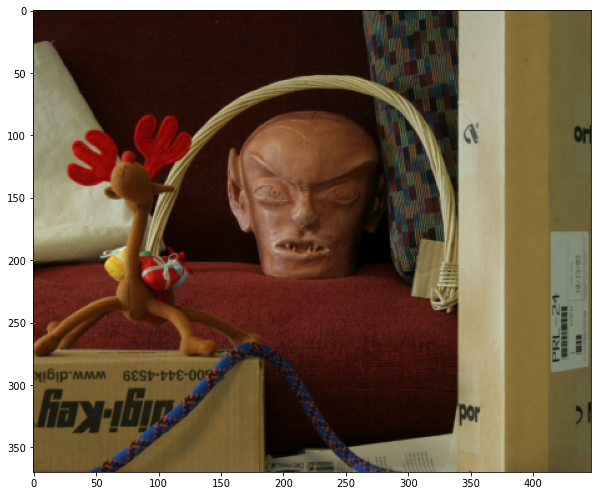

In [129]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(img_left)

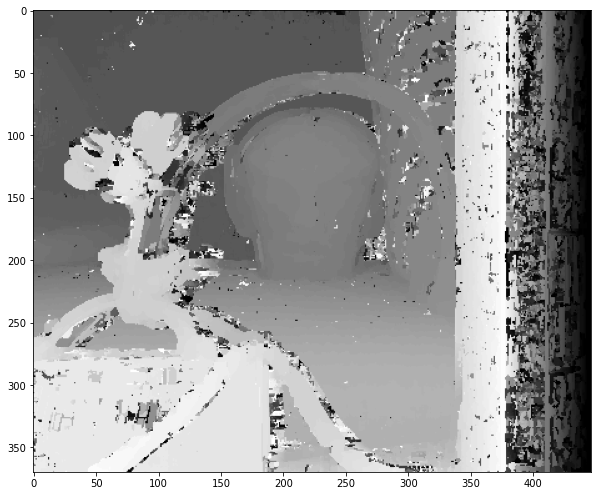

In [130]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(dpm, cmap='gray')

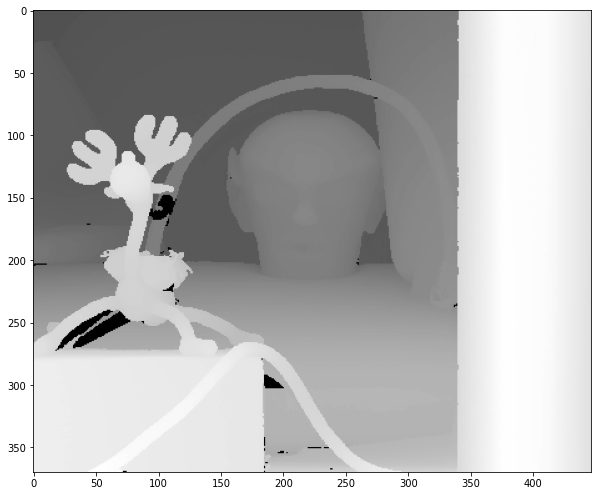

In [131]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(dpm_gr, cmap='gray')

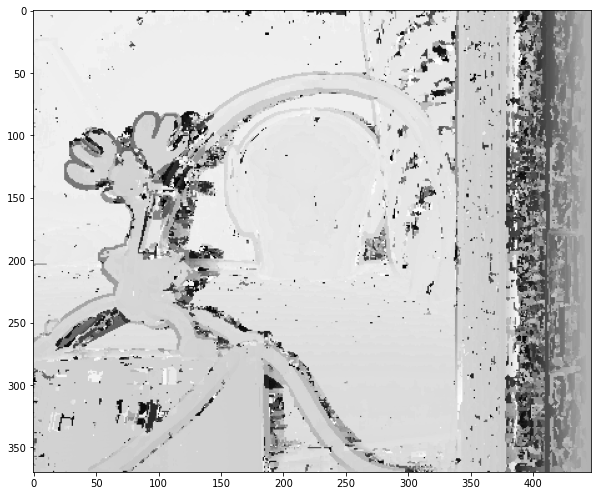

In [132]:
dpm_diff = dpm_gr - dpm

fig = plt.figure(figsize=(10, 10))
plt.imshow(dpm_diff, cmap='gray')

## Stereo reconstruction of the 3D scene from the ground truth disparity map

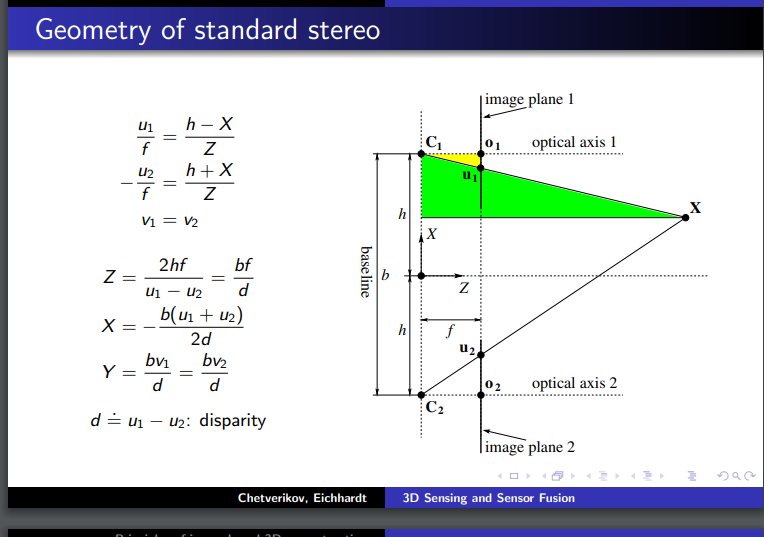

In [133]:
param_baseline = 160 # mm
param_focal_length = 3740 # pixels
dmin = 230

points_gr = reconstruct_3d_scene(
    img_left,
    dpm_gr / 3, 
    param_baseline / 1000, 
    param_focal_length, 
    dmin
)

In [134]:
path_points = os.path.join(os.getcwd(), 'points_3d')
fn_points = f'{img_set}_3d_scene_gr.txt'

with open(os.path.join(path_points, fn_points), 'w') as file:
    for point in points_gr:
        file.write(' '.join(str(p) for p in point))
        file.write('\n')

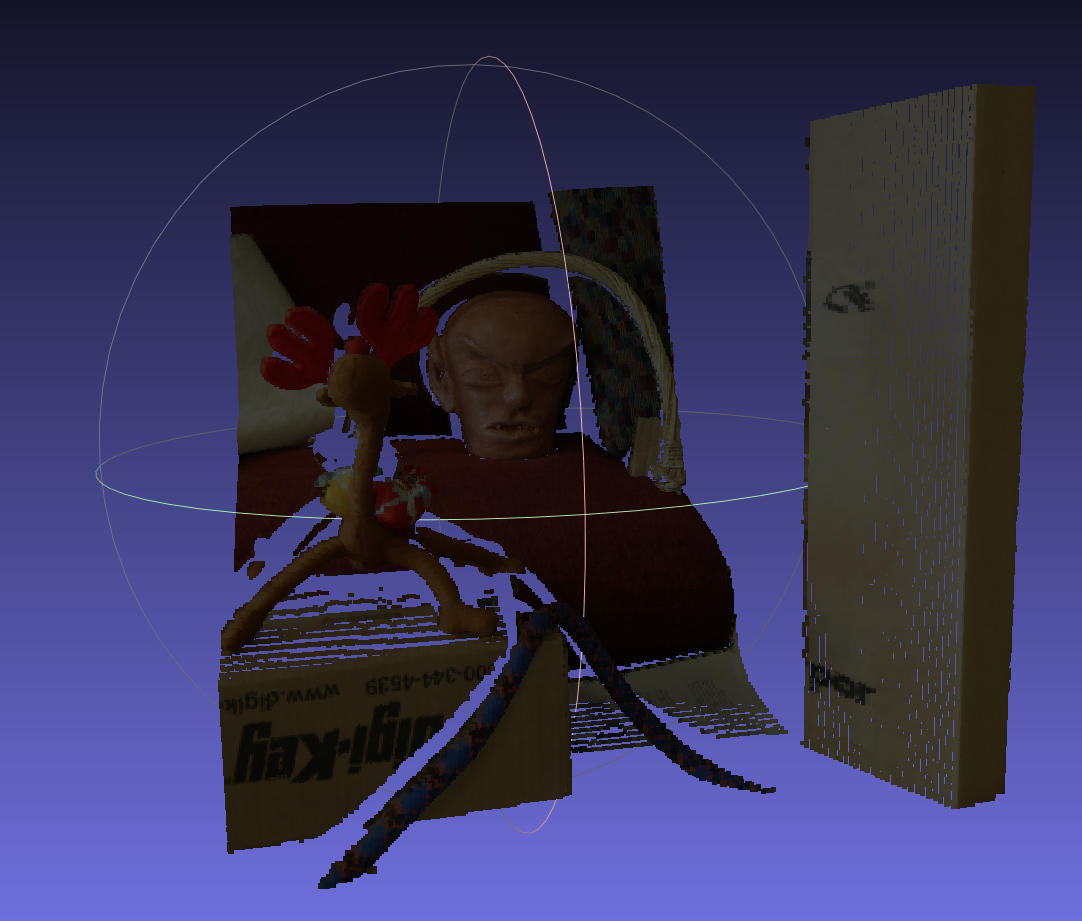

## Stereo reconstruction of the 3D scene from the calculated disparity map

In [136]:
points_naive = reconstruct_3d_scene(
    img_left,
    dpm / 3, 
    param_baseline / 1000, 
    param_focal_length, 
    dmin
)
fn_points = f'{img_set}_3d_scene_naive.txt'

with open(os.path.join(path_points, fn_points), 'w') as file:
    for point in points_naive:
        file.write(' '.join(str(p) for p in point))
        file.write('\n')

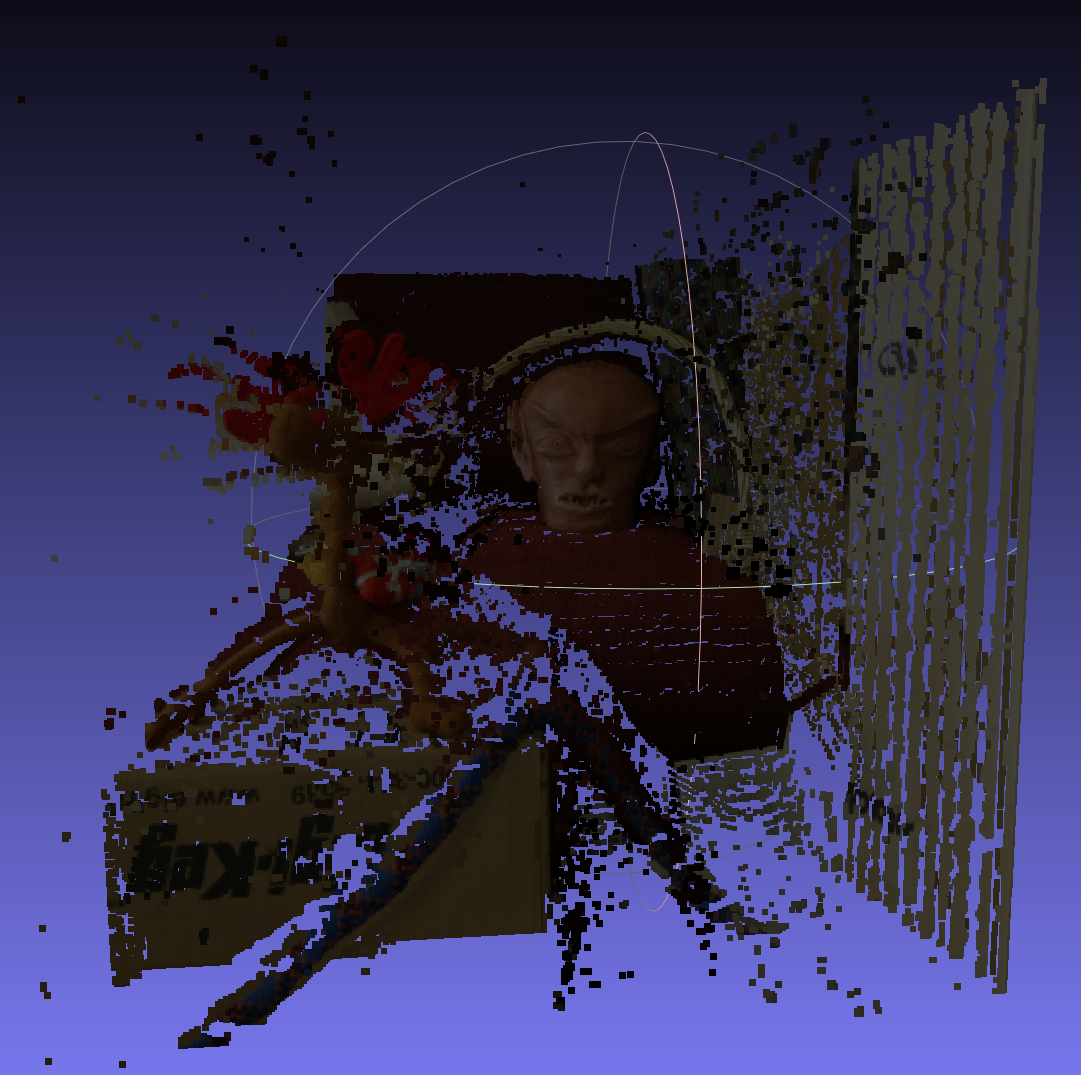